<a href="https://colab.research.google.com/github/marissa-graham/multiagent_systems/blob/master/Lab_1(Repeated_Play_Prisoner's_Dilemma).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np

class Agent:
    """
    Model different agent strategies for a single game.
    """
    
    def __init__(self, strategy):
        
        self.strategies = {'AD', 'r50', 'AC', 'TfT', 'Tf2T', 'Pavlov', 
                           'WS-LS', 'NF', 'D&C', 'CD', 'r25', 'r75'}
        if strategy not in strategies:
            raise ValueError("Strategy not recognized")
            
        self.strategy = strategy
        self.my_actions = []
        self.your_actions = []
        self.payoffs = []
        
        self.our_strategy = 1
        
    def next_move(self):
        """
        Cooperate is 1 and defect is 0.
        
        Math explanations
        -----------------
        
        Tf2T: Only defect if they've defected the last two times
           => my_next_move = mean of their last two moves, rounded up
        
        WS-LS (entries of matrix: my next move)
            Do the same thing if I won (aka we both cooperated, or I defected 
          while you cooperated), and switch otherwise.
          
                        My last move
                           _1___0_
        Their last move 1 |_1_|_0_|
                        0 |_0_|_1_|
                
           => my_next_move = 1 - (their_last_move + my_last_move) % 2
           
        Pavlov (entries of matrix: my next move)
            Cooperate if we did the same thing last time, and defect otherwise.
            
                        My last move
                           _1___0_
        Their last move 1 |_1_|_0_|
                        0 |_0_|_1_|
                
           => my_next_move = 1 - (their_last_move + my_last_move) % 2
          
        Pavlov and WS-LS are the SAME.
        """
        
        # Strategies where previous choices have no impact
        
        if self.strategy == 'AD':
            return 0
        
        elif self.strategy == 'AC':
            return 1
        
        elif self.strategy in {'r25', 'r50', 'r75'}:
            
            # Cooperate with probability p
            p = 0.01*int(self.strategy[1:])
            
            # If a uniformly drawn random number in [0,1] is < p, cooperate
            if np.random.uniform() < p:
                return 1
            else:
                return 0
            
        else:
            
            # All of the rest of the strategies begin by cooperating
            if len(self.your_actions) < 1:
                return 1
            
            # If there's been at least one turn
            else:
                
                # Strategies that depend only on the your previous actions
                if self.strategy == 'TfT':
                    return self.your_actions[-1]  

                elif self.strategy == 'Tf2T':
                    if len(self.your_actions) < 2:
                        return 1
                    else:
                        return np.ceil(np.mean(self.your_actions[-2:]))

                elif self.strategy == 'NF':
                    return min(self.your_actions)
                
                elif self.strategy == 'CD':
                    return (self.my_actions[-1] + 1) % 2

                # Strategies that depend both of our previous actions
                elif self.strategy == 'Pavlov' or self.strategy == 'WS-LS':
                    return 1 - (self.your_actions[-1] + self.my_actions[-1]) % 2
                
                # Our strategy (slow to anger, slow to forgive)
                elif self.strategy == 'D&C':
                    
                    if len(self.your_actions) >= 4:
                        your_last4 = self.your_actions[-4:]
                        
                        # If you've been doing the same thing the last 4 turns
                        if np.max(your_last4) == np.min(your_last4):
                            
                            # AND it's not the same thing I've been doing
                            if self.your_actions[-1] != self.our_strategy:
                                
                                # Switch
                                self.our_strategy = (self.our_strategy + 1) % 2
                    
                    return self.our_strategy
class Game:
    
    def __init__(self, strategy1, strategy2, length):
    
        self.player1 = Agent(strategy1)
        self.player2 = Agent(strategy2)
        self.rewards = {(1,0):(1,5), (0,1):(5,1), (1,1):(3,3), (0,0):(2,2)}
        
        if length <= 0:
            raise ValueError("Invalid game length")
            
        self.length = length
        
        self.result = self.play_game()
        self.num_turns = len(self.player1.my_actions)
        
    def play_turn(self):
        """
        It turns out that when we represent cooperation with a 1 and defection 
        with a 0, my payoff for the Prisoner's dilemma with the given payoff
        matrix is 2 + 3*your_move - my_move - your_move*my_move.
        """
        
        orders = ((self.player1, self.player1.next_move()), 
                  (self.player2, self.player2.next_move()))
        
        for player_tuple in [orders, orders[::-1]]:
            
            me, my_move = player_tuple[0]
            you, your_move = player_tuple[1]
            
            me.my_actions.append(my_move)
            me.your_actions.append(your_move)
            me.payoffs.append(2 + 3*your_move - my_move - my_move*your_move)      
    
    def play_game(self):
        
        # Play the game
        if self.length >= 1:
            for i in range(self.length):
                self.play_turn()
        else:
            while True:
                self.play_turn()
                if np.random.rand() > self.length:
                    break
                    
        return (sum(self.player1.payoffs), sum(self.player2.payoffs))

In [0]:
lengths =  [5, 100, 200, 0.75, 0.9, 0.99]
strategies = ['AD', 'r25', 'r50', 'r75', 'AC', 'CD', 'NF', 'D&C', 'TfT', 'Tf2T',
              'Pavlov', 'WS-LS']
game_matrices = dict()
variance_matrices = dict()

n = len(strategies)
num_trials = 1000

for length in lengths:
    
    game_matrix = np.zeros((n,n,2))
    variance_matrix = np.zeros((n,n,2))
    
    for i in range(n):
        print(length, strategies[i])
        for j in range(n):
           
            p1 = strategies[i]
            p2 = strategies[j]
            
            # If we have randomness, take the average of 1000 experiments
            trials = np.zeros((2,num_trials))
            if length < 1:
                for k in range(num_trials):
                    trial = Game(p1,p2,length)
                    trials[:,k] = np.array(trial.result)/trial.num_turns
                
                game_matrix[i,j,:] = np.mean(trials, axis=1)
                variance_matrix[i,j,:] = np.var(trials, axis=1)  
            elif p1[0] == 'r' or p2[0] == 'r':
                for k in range(num_trials):
                    trials[:,k] = np.array(Game(p1,p2,length).result)
                
                game_matrix[i,j,:] = np.mean(trials, axis=1)
                variance_matrix[i,j,:] = np.var(trials, axis=1)  
            else:
                game_matrix[i,j,:] = Game(p1,p2,length).result
    
    game_matrices[length] = game_matrix
    variance_matrices[length] = variance_matrix

5 AD
5 r25
5 r50
5 r75
5 AC
5 CD
5 NF
5 D&C
5 TfT
5 Tf2T
5 Pavlov
5 WS-LS
100 AD
100 r25
100 r50
100 r75
100 AC
100 CD
100 NF
100 D&C
100 TfT
100 Tf2T
100 Pavlov
100 WS-LS
200 AD
200 r25
200 r50
200 r75
200 AC
200 CD
200 NF
200 D&C
200 TfT
200 Tf2T
200 Pavlov
200 WS-LS
0.75 AD
0.75 r25
0.75 r50
0.75 r75
0.75 AC
0.75 CD
0.75 NF
0.75 D&C
0.75 TfT
0.75 Tf2T
0.75 Pavlov
0.75 WS-LS
0.9 AD
0.9 r25
0.9 r50
0.9 r75
0.9 AC
0.9 CD
0.9 NF
0.9 D&C
0.9 TfT
0.9 Tf2T
0.9 Pavlov
0.9 WS-LS
0.99 AD
0.99 r25
0.99 r50
0.99 r75
0.99 AC
0.99 CD
0.99 NF
0.99 D&C
0.99 TfT
0.99 Tf2T
0.99 Pavlov
0.99 WS-LS


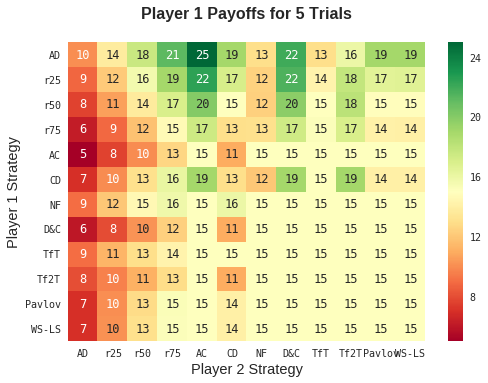

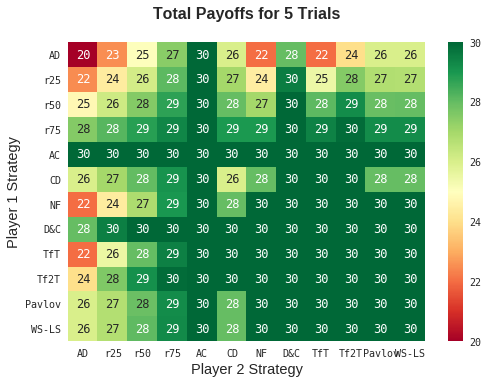

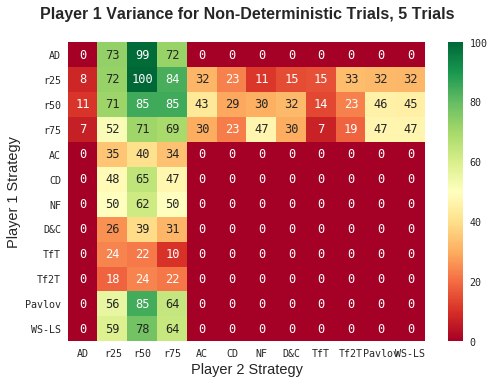

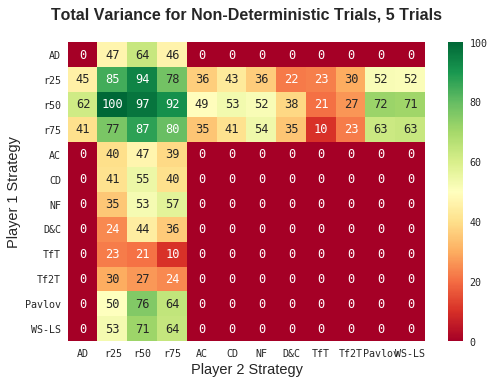

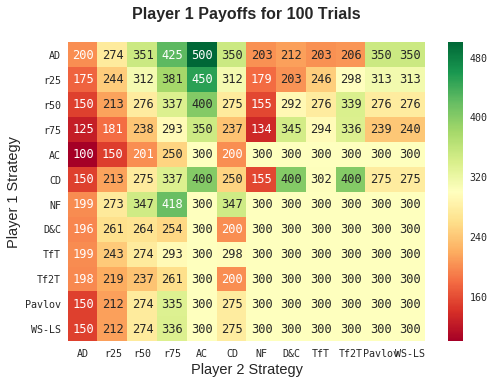

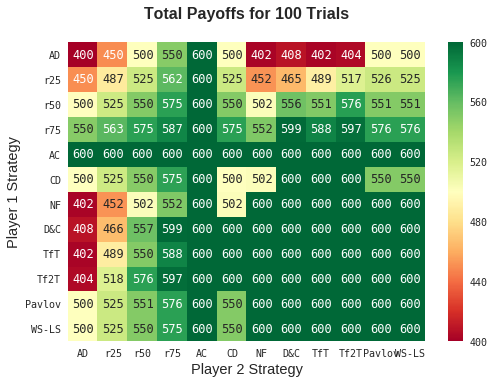

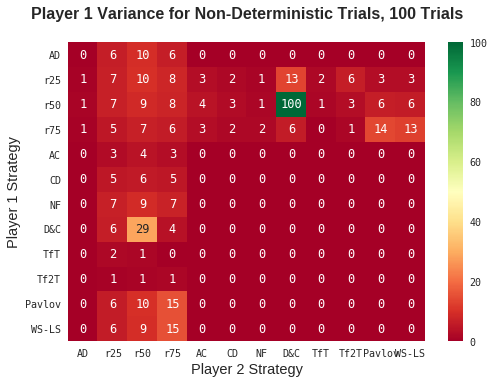

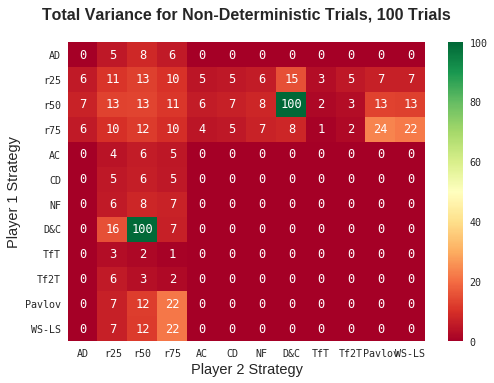

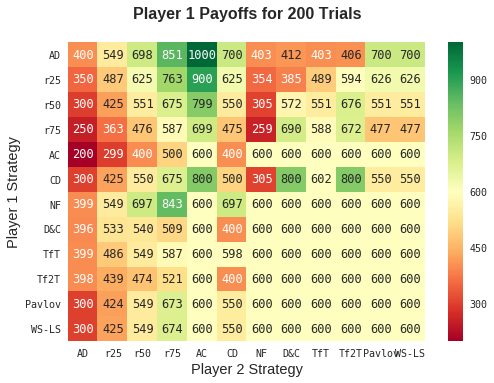

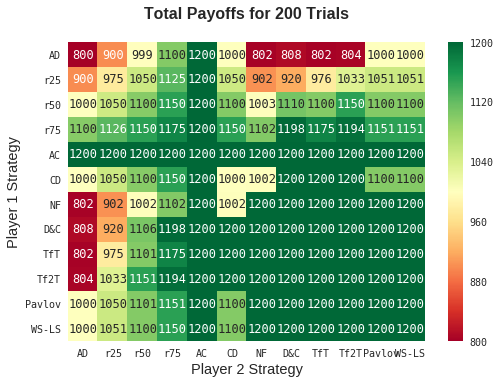

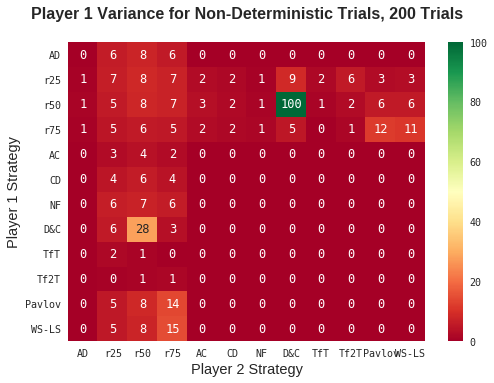

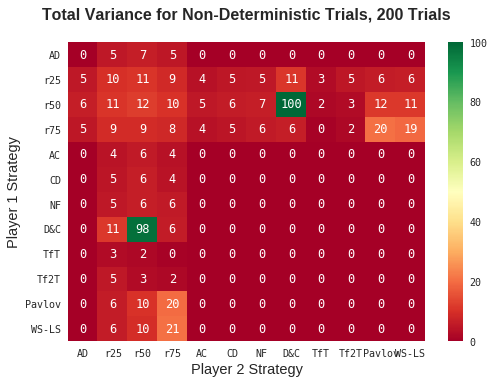

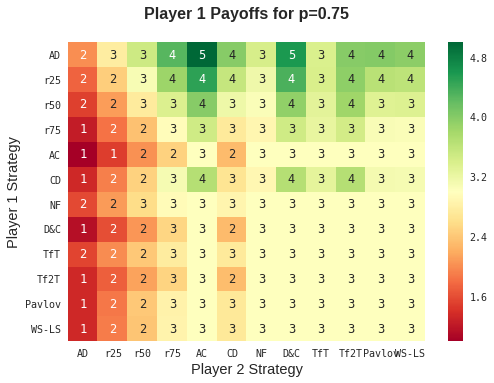

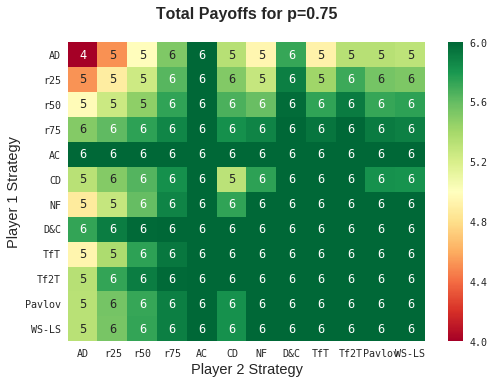

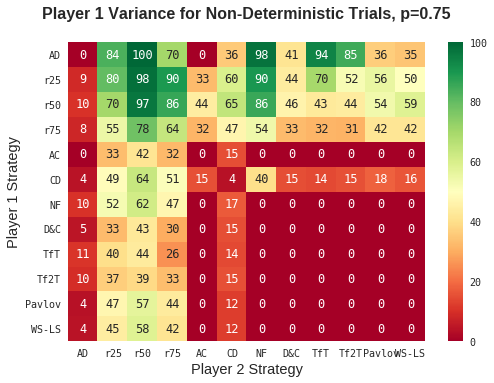

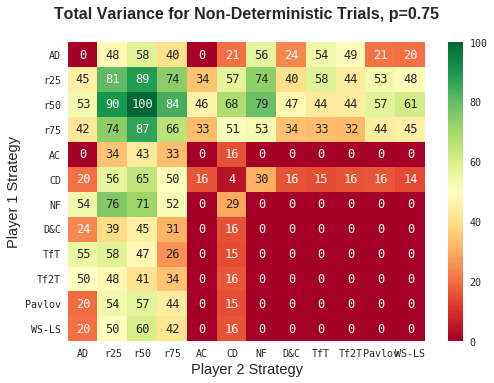

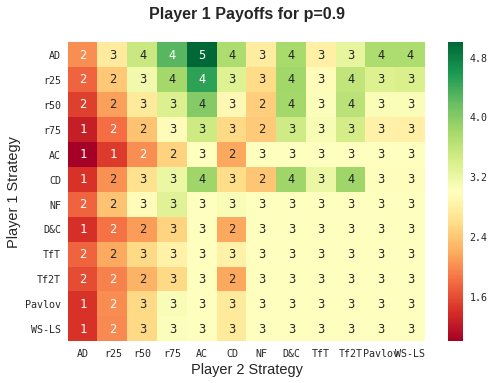

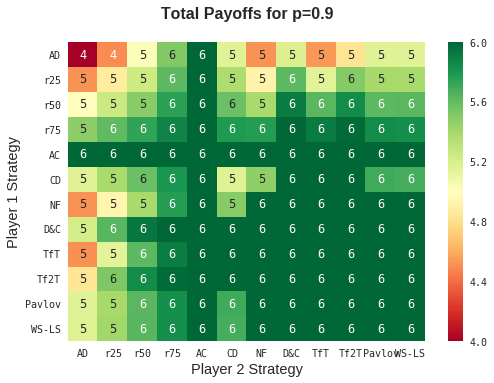

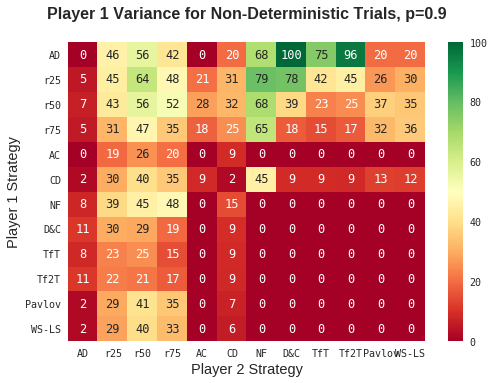

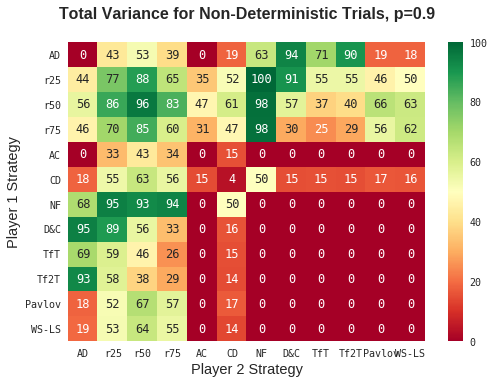

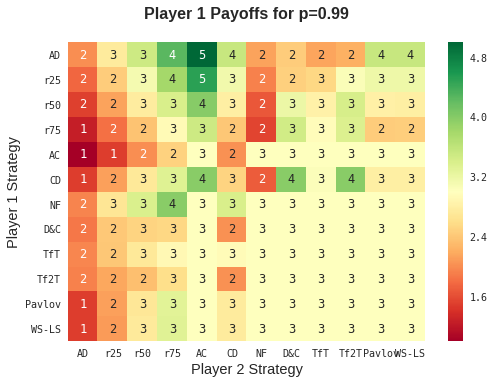

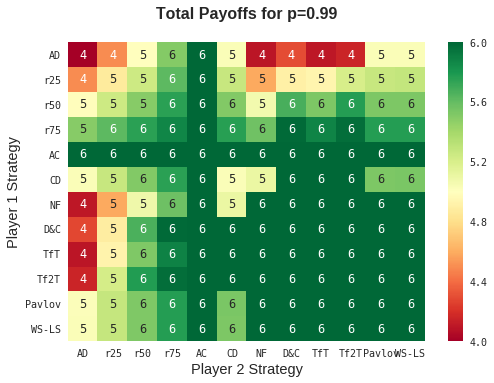

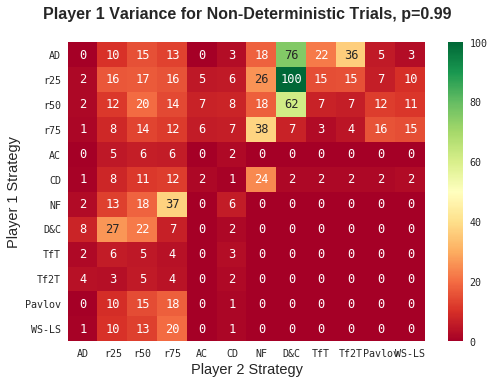

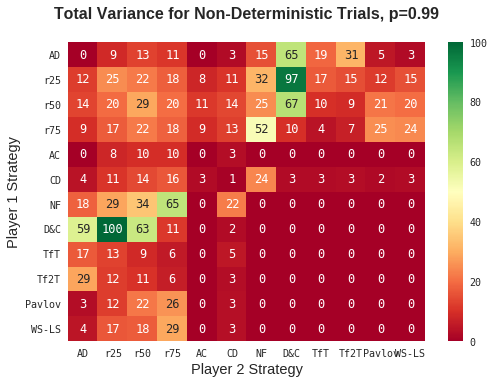

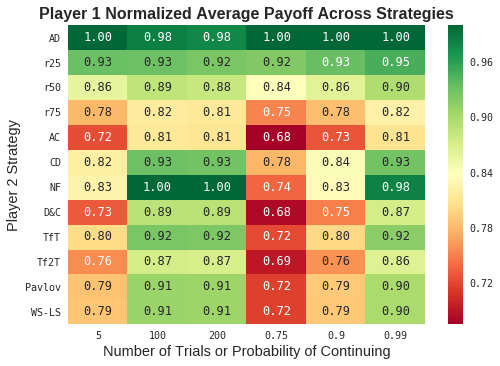

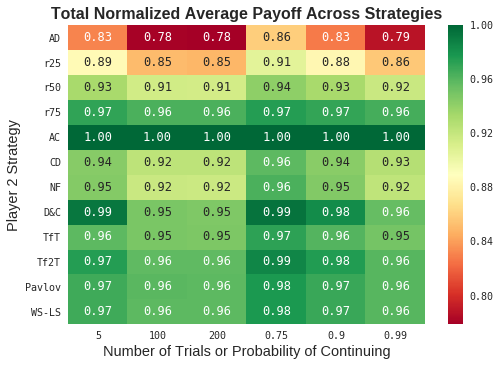

In [0]:
from matplotlib import pyplot as plt
import seaborn
seaborn.set(font='monospace',font_scale=1)

titlefont = {'weight':'semibold','family':'sans-serif','fontsize':16}
labelfont = {'family':'sans-serif','fontsize':14.5}

def plot_matrix(G, title, l=-1, extend_stub=True, fmt=".0f"):
    ax = seaborn.heatmap(G, cmap='RdYlGn', annot=True,
                    fmt=fmt, xticklabels=strategies, yticklabels=strategies)
    title_stub = title
    if extend_stub:
        if l > 1:
            title_stub += str(l) + " Trials\n"
        elif l > 0:
            title_stub += "p=" + str(l) + "\n"
    ax.set_title(title_stub, fontdict=titlefont)
    ax.set_xlabel("Player 2 Strategy", fontdict=labelfont)
    ax.set_ylabel("Player 1 Strategy", fontdict=labelfont)
    plt.show()
    
def plot_matrixLS(G, title):
    
    ax = seaborn.heatmap(G, cmap='RdYlGn', annot=True, fmt=".2f", 
                         xticklabels=lengths, yticklabels=strategies)
    ax.set_title(title, fontdict=titlefont)
    ax.set_xlabel("Number of Trials or Probability of Continuing", fontdict=labelfont)
    ax.set_ylabel("Player 2 Strategy", fontdict=labelfont)
    plt.show()

# PAYOFFS FOR EACH STRATEGY AGAINST OTHERS, COLUMNS = GAME LENGTH  

for s in range(len(strategies)):
    
    strategy_matrix = np.zeros((len(strategies),len(lengths)))
    for i in range(len(strategies)):
        for j in range(len(lengths)):
            g = game_matrices[lengths[j]]
            strategy_matrix[i,j] = g[s,i,0]/np.max(g[:,:,0])
    
    #plot_matrixLS(strategy_matrix, "Payoffs for "+strategies[s]+
    #            " against other strategies\n" + 
    #            "(normalized by best payoff for Player 1 for each game length)")
    
# PAYOFFS AND VARIANCE FOR STRATEGY VS STRATEGY FOR EACH GAME LENGTH

p1_totals = np.zeros((len(strategies),len(lengths)))
total_totals = np.zeros((len(strategies),len(lengths)))

for i in range(len(lengths)):
    
    g = game_matrices[lengths[i]]
    
    #plot_matrix(g[:,:,0] - g[:,:,1], "Player 1 Advantage for ")
    plot_matrix(g[:,:,0], "Player 1 Payoffs for ", l=lengths[i])
    plot_matrix(g[:,:,0] + g[:,:,1], "Total Payoffs for ", l=lengths[i])
    
    v = variance_matrices[lengths[i]]
    v_norm_p1 = 100*v[:,:,0]/np.max(v[:,:,0])
    v_norm_tot = 100*(v[:,:,0] + v[:,:,1])/np.max(v[:,:,0]+v[:,:,1])
                                              
    plot_matrix(v_norm_p1, "Player 1 Variance for Non-Deterministic Trials, ",
                  lengths[i], fmt=".0f")
    plot_matrix(v_norm_tot, "Total Variance for Non-Deterministic Trials, ", 
                  lengths[i], fmt=".0f")
    
    p1_totals[:,i] = np.mean(g[:,:,0],axis=1)
    p1_totals[:,i] /= np.max(p1_totals[:,i])
    total_totals[:,i] = np.mean(g[:,:,0]+g[:,:,1],axis=1)
    total_totals[:,i] /= np.max(total_totals[:,i])

# NORMALIZED AVERAGE PAYOFF ACROSS STRATEGIES FOR EACH STRATEGY, BY GAME LENGTH

plot_matrixLS(p1_totals, "Player 1 Normalized Average Payoff Across Strategies")
plot_matrixLS(total_totals, "Total Normalized Average Payoff Across Strategies")